### General Imports

In [13]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import os
import glob
import json
import matplotlib.pyplot as plt
from cleanUp import cleanUp

### Data Cleaning
Cleaning out 0 entries and any entries not in the timerange we are looking at.
Then dealing with sensors having different time zones

In [14]:
all_csv_files = glob.glob("./Data/*.txt")
loops=len(all_csv_files)
# insert the desired start time
cutOffTime = '12/22/2020 12:49'
# insert the time rectifying offsets. default of for nothing {'':0}
sensorConditions = {'BU':8,'S-':1}
columns = [0,1,6,7,8,9,10]
data = cleanUp(cutOffTime,{'':0},all_csv_files,columns)

S-01  NO DATA PRESENT    NO DATA PRESENT
S-02  NO DATA PRESENT    NO DATA PRESENT
S-03  NO DATA PRESENT    NO DATA PRESENT
S-04  NO DATA PRESENT    NO DATA PRESENT
S-05  NO DATA PRESENT    NO DATA PRESENT
S-06  NO DATA PRESENT    NO DATA PRESENT
S-07  NO DATA PRESENT    NO DATA PRESENT
S-08  NO DATA PRESENT    NO DATA PRESENT
S-09  NO DATA PRESENT    NO DATA PRESENT
S-11  NO DATA PRESENT    NO DATA PRESENT
S-12  NO DATA PRESENT    NO DATA PRESENT
S-13  NO DATA PRESENT    NO DATA PRESENT
S-14  NO DATA PRESENT    NO DATA PRESENT
S-15  NO DATA PRESENT    NO DATA PRESENT
S-BU1  NO DATA PRESENT    NO DATA PRESENT
S-BU2  NO DATA PRESENT    NO DATA PRESENT


### Exporting Data
Here we can export the organized data frames as csv files

In [7]:
for x in data:
    temp=data[x]
    location = os.path.join('./proccessedData',x+'.csv')
    temp.to_csv(location,index=False)

### Checking Data
Here we scan through the data for irregularities in data recording.

In [8]:
errors = {}
errorCount = {}
# Enter the expected interval here
interval = 10
for x in data:
    # errors keeps track of length of each time interval error that occurs
    errors[x] = set(())
    # errorCount keeps track of how many times each time interval error occured
    errorCount[x] = {}
    # counter keeps track of the total time interval errors per sensor
    counter = 0
    temp = data[x]
    for idx,i in enumerate(temp['Date_Time']):
        try:
            if not ((temp['Date_Time'][idx+1] - i) == pd.Timedelta(seconds=interval)):
                timeErr = temp['Date_Time'][idx+1] - i
                if str(timeErr.seconds) in errorCount[x]:
                    errorCount[x][str(timeErr.seconds)] +=1
                else:
                    errorCount[x][str(timeErr.seconds)] = 1

                errors[x].add(timeErr)


                counter += 1
        except:
            continue

    print(str(counter),' possible errors in ', x)
    # display the different types of errors
    lst = [i.seconds for i in errors[x]]
    frmt = "{:>4}"*len(lst)
    print(frmt.format(*lst))
    # display the quantity of each type of error
    lst = [errorCount[x][str(i.seconds)] for i in errors[x]]
    frmt = "{:>4}"*len(lst)
    print(frmt.format(*lst))
    print()

216  possible errors in  S-01
  26  21  17  13  19  30  20  27  11
   1   1   6   1   2   1 202   1   1

0  possible errors in  S-02



227  possible errors in  S-03
  21  12  25  27  16  18  62  84  51  20  31  11  22   9  13   0  90  15  70  59  17  19  63
   1   2   1   3   1   7   2   1   1 178   1   3   2   1   1   1   1   1   1   1  12   4   1

228  possible errors in  S-04
  21  22  17  23  60  18  35  24  78  19  20  13  25  27  11  49
   1   2  12   1   1  10   3   1   1   2 187   1   1   1   3   1

228  possible errors in  S-05
  26  21  16  17  23  12  18   7  19  24  25  20  15  27
   1   4   1  10   2   1   7   1   2   1   1 195   1   1

208  possible errors in  S-06
  28  17  85  20
   1   1   1 205

221  possible errors in  S-07
   9  16  22  14  12  34  18  24  19  30  25  20  15  17  13  27  11
   1   1   2   1   1   1   1   1   9   2   1 192   2   2   1   1   2

426  possible errors in  S-08
  34  35 138 139 140  37
 170 249   3   2   1   1

5  possible errors in  S-0

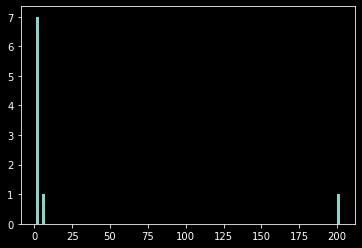

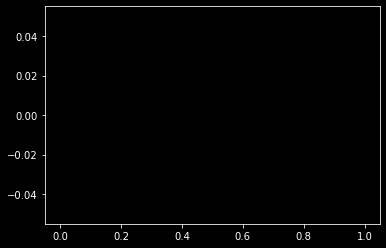

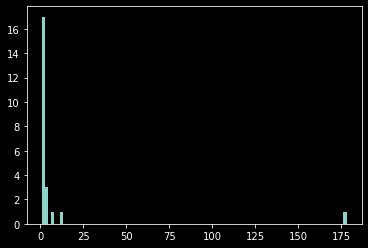

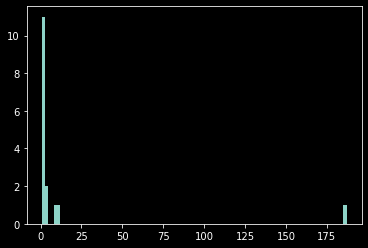

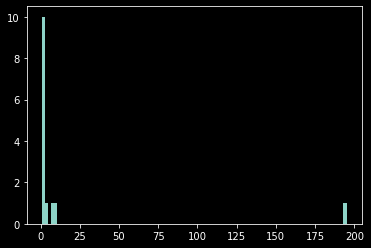

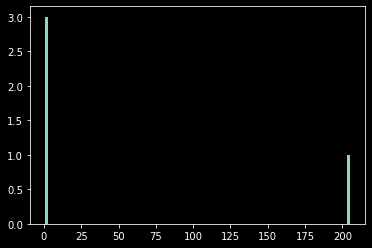

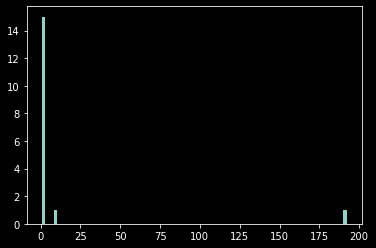

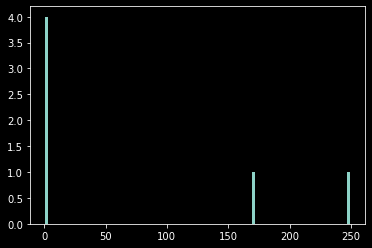

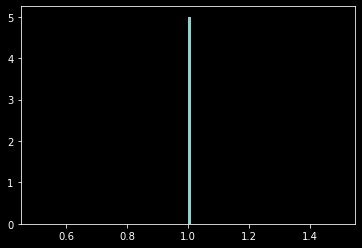

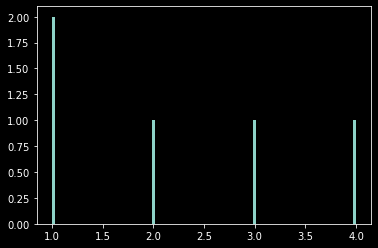

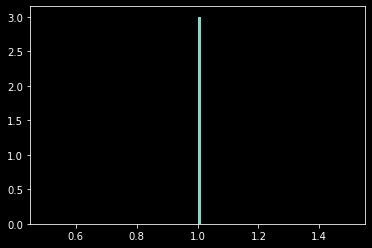

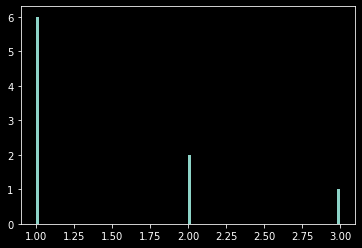

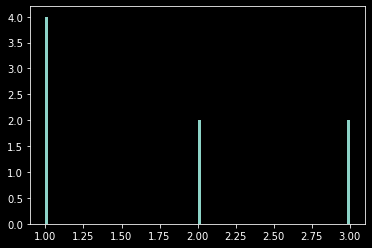

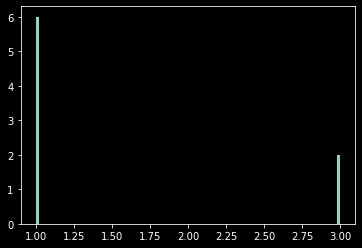

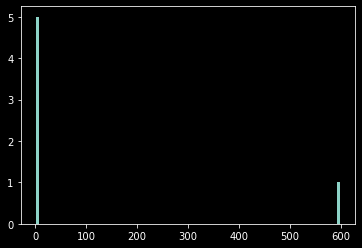

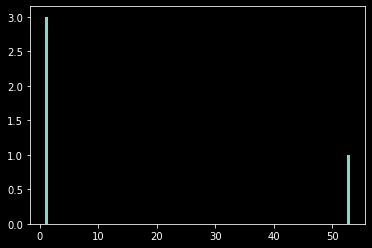

In [9]:
for idx,x in enumerate(data):
    fig = plt.figure(idx)
    ax = fig.gca()
    plt.hist([errorCount[x][str(i.seconds)] for i in errors[x]],bins=100)
    plt.show

In [10]:
'apple' in fruits

NameError: name 'fruits' is not defined